In [1]:
import numpy as np
from ctypes import *
import matplotlib.pyplot as plt

### Tests the generation of a random bit sequence

In [2]:
outFile = "/home/silas/Documents/GitHub/TDI/dsp.so"
dsp = CDLL(outFile)

dsp.getRandomBits.argtypes = [c_int, c_int]
dsp.getRandomBits.restype  = POINTER(c_int)

In [3]:
M = 16
Nbits = 100000

bits   = dsp.getRandomBits(Nbits, M)
# converte o ponteiro para um array numpy
BitsTx = np.ctypeslib.as_array(bits, shape=(Nbits,))

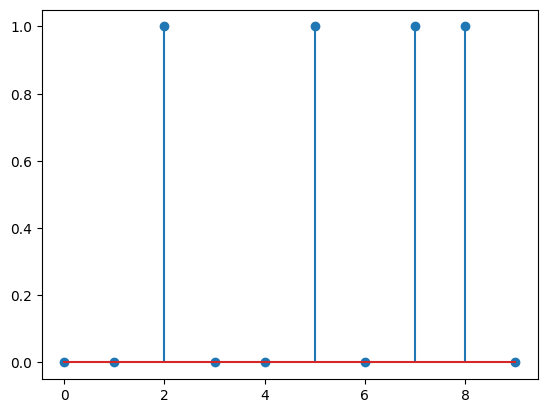

In [4]:
plt.stem(BitsTx[0:10]);